In [10]:
from utils import *
import numpy as np
import matplotlib.pyplot as plt

In [11]:
pwsize = "results/wsize_str_knn_rf_1691348920/knn_f1.pkl"
palpha = "results/str_knn_rf_1691345574/knn_f1.pkl"
pwsize = open_pkl(pwsize)
palpha = open_pkl(palpha)
palpha[1] = palpha[-1]
del palpha[-1]

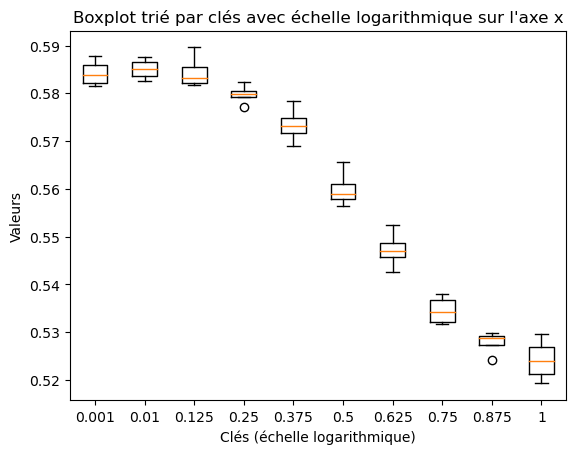

In [39]:
import matplotlib.pyplot as plt

data = palpha



sorted_keys = sorted(data.keys())

# Tri des valeurs associées aux clés
sorted_values = [data[key] for key in sorted_keys]

# Création du graphe boxplot avec échelle logarithmique sur l'axe x
plt.boxplot(sorted_values, labels=sorted_keys)
plt.xlabel('Clés (échelle logarithmique)')
plt.ylabel('Valeurs')
plt.title('Boxplot trié par clés avec échelle logarithmique sur l\'axe x')
# plt.xscale('log')  # Définition de l'échelle logarithmique sur l'axe x
plt.show()


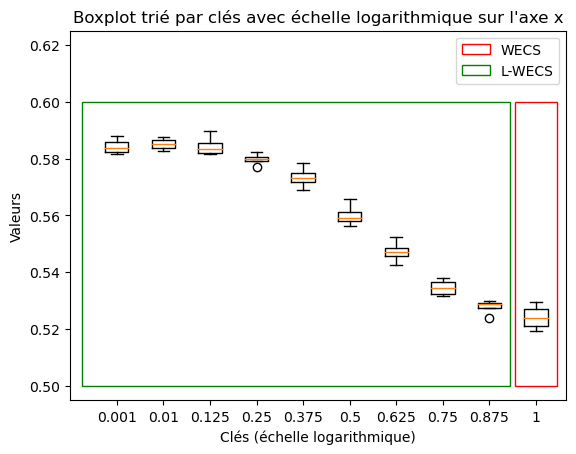

In [99]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


data = palpha
# Tri des clés par ordre croissant
sorted_keys = sorted(data.keys())

# Tri des valeurs associées aux clés
sorted_values = [data[key] for key in sorted_keys]

# Création du graphe boxplot avec échelle logarithmique sur l'axe x
plt.boxplot(sorted_values, labels=sorted_keys)
plt.xlabel('Clés (échelle logarithmique)')
plt.ylabel('Valeurs')
plt.title('Boxplot trié par clés avec échelle logarithmique sur l\'axe x')

# Ajout d'un rectangle rouge autour de la boîte correspondant à la clé 'key_2'
plt.gca().add_patch(Rectangle((len(sorted_keys)-.455, 0.5), 0.9, 0.1, fill=False, edgecolor='red', lw=1,label='WECS'))
plt.gca().add_patch(Rectangle((0.25, 0.5), len(sorted_keys)-.8, 0.1, fill=False, edgecolor='green', lw=1,label='L-WECS'))
plt.ylim(0.495, 0.625)
plt.legend()#loc='upper right', framealpha=1, title='Légende')
plt.xlim(0, len(sorted_keys)+0.65)




plt.show()



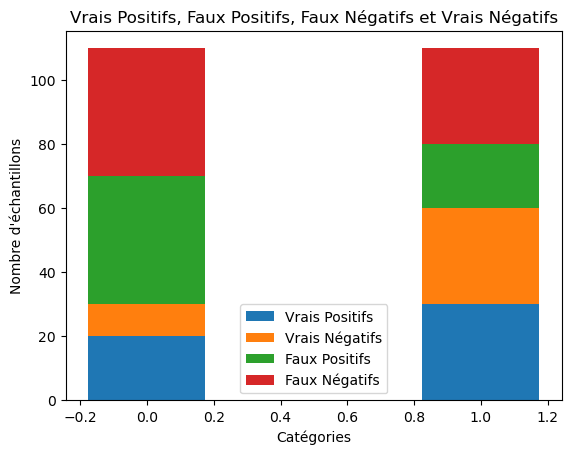

In [113]:
import matplotlib.pyplot as plt

# Exemple de valeurs prédites (ypred) et valeurs réelles (y) pour les deux exemples
ypred_1 = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1]
y_1 = [1, 1, 0, 0, 1, 0, 1, 0, 1, 0]

ypred_2 = [0, 1, 1, 0, 1, 0, 1, 1, 0, 0]
y_2 = [1, 1, 0, 0, 1, 0, 1, 0, 1, 0]

# Fonction pour calculer les valeurs TP, FP, FN, TN
def calculate_metrics(ypred, y):
    TP = sum(1 for p, t in zip(ypred, y) if p == 1 and t == 1)
    FP = sum(1 for p, t in zip(ypred, y) if p == 1 and t == 0)
    FN = sum(1 for p, t in zip(ypred, y) if p == 0 and t == 1)
    TN = sum(1 for p, t in zip(ypred, y) if p == 0 and t == 0)
    total_samples = len(ypred)
    TP_prop = TP / total_samples * 100
    FP_prop = FP / total_samples * 100
    FN_prop = FN / total_samples * 100
    TN_prop = TN / total_samples * 100


    return TP_prop, FP_prop, FN_prop, TN_prop

# Calcul des valeurs TP, FP, FN, TN pour chaque exemple
TP_1, FP_1, FN_1, TN_1 = calculate_metrics(ypred_1, y_1)
TP_2, FP_2, FN_2, TN_2 = calculate_metrics(ypred_2, y_2)

# Création des barplots empilés
categories = ['Vrais Positifs', 'Vrais Négatifs', 'Faux Positifs', 'Faux Négatifs']
values_1 = [TP_1, TN_1, FP_1, FN_1, ]
values_2 = [TP_2, TN_2, FP_2, FN_2, ]

bar_width = 0.35
index = 2

z=0
z2=0
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
for n,i in enumerate(values_1):
    plt.bar(0, values_1, bar_width,bottom=z,color=colors[n],label=None)
    z=z+i
for n,i in enumerate(values_2):
    plt.bar(1, values_2, bar_width, bottom=z2,color=colors[n],label=categories[n])
    z2=z2+i

plt.xlabel('Catégories')
plt.ylabel('Nombre d\'échantillons')
plt.title('Vrais Positifs, Faux Positifs, Faux Négatifs et Vrais Négatifs')
# plt.xticks([i + bar_width / 2 for i in index], categories)
plt.legend()
plt.show()


In [11]:
import numpy as np
import os, sys

sys.path.append("../")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from utils import load_h5, random_shuffle
from tensorflow.keras.utils import to_categorical


def balance_dataset(X, Y, shuffle=False):
    """Balance the dataset by taking the minimum number of samples per class (under-sampling)

    Parameters
    ----------
    X : numpy array
        dataset of images in float32, shape (n_samples, height, width, n_bands)

    Y : numpy array
        dataset of labels in string, shape (n_samples,)

    shuffle : bool, optional
        Shuffle the dataset, by default False

    Returns
    -------
    numpy array
        balanced dataset of images in float32, shape (n_samples, height, width, n_bands)

    numpy array
        balanced dataset of labels in string, shape (n_samples,)
    """
    if shuffle:
        X, Y = random_shuffle(X, Y)
    cat, counts = np.unique(Y, return_counts=True)
    min_count = np.min(counts)
    X_bal = []
    Y_bal = []
    for category in cat:
        idx = np.where(Y == category)[0]
        idx = idx[:min_count]
        X_bal.append(X[idx])
        Y_bal.append(Y[idx])
    X_bal = np.concatenate(X_bal)
    Y_bal = np.concatenate(Y_bal)
    return X_bal, Y_bal


def prepare_data(
    path,
    band_max=[0, 1, 2],
    balanced=True,
    shuffle=True,
):
    """Prepare the data for the CNN model, it suppose that the data are stored in hdf5 files in the same folder and named "data_train.h5" and "data_test.h5"

    Parameters
    ----------
    ipath : str
        Path to the hdf5 files

    frac_val : float, optional
        Fraction of the dataset to use for validation, by default 0.15

    band_max : list, optional
        List of the bands to use, by default [0, 1, 6, 7]

    balanced : list, optional
        List of boolean to balance the dataset train and test, by default [False, False]

    shuffle : bool, optional
        Shuffle the dataset (seed=42), by default True

    categorical : bool, optional
        If True, encode the labels using to_categorical, by default False

    Returns
    -------
    numpy array
        dataset of images in float32, shape (n_samples, height, width, n_bands) of the train set

    numpy array
        dataset of labels in string, shape (n_samples,) of the train set

    numpy array
        dataset of images in float32, shape (n_samples, height, width, n_bands) of the test set

    numpy array
        dataset of labels in string, shape (n_samples,) of the test set

    numpy array
        dataset of images in float32, shape (n_samples, height, width, n_bands) of the validation set

    numpy array
        dataset of labels in string, shape (n_samples,) of the validation set

    sklearn.preprocessing.LabelEncoder
        LabelEncoder object to transform the labels into integers
    """
    X, Y = load_h5(path)
    if band_max is not None:
        X = X[:, :, :, band_max]

    if shuffle:
        X, Y = random_shuffle(X, Y)
    Y = np.where(Y != "no change", "change", Y)

    if balanced:
        X, Y = balance_dataset(X, Y)

    Le = LabelEncoder()
    y = Le.fit_transform(Y)

    X = X.reshape(X.shape[0], -1)
    return X, y, Le


def prepare_data_split(
    path,
    band_max=[0, 1, 2],
    balanced=[False, False],
    shuffle=True,
):
    """Prepare the data for the CNN model, it suppose that the data are stored in hdf5 files in the same folder and named "data_train.h5" and "data_test.h5"

    Parameters
    ----------
    ipath : str
        Path to the hdf5 files

    frac_val : float, optional
        Fraction of the dataset to use for validation, by default 0.15

    band_max : list, optional
        List of the bands to use, by default [0, 1, 6, 7]

    balanced : list, optional
        List of boolean to balance the dataset train and test, by default [False, False]

    shuffle : bool, optional
        Shuffle the dataset (seed=42), by default True

    categorical : bool, optional
        If True, encode the labels using to_categorical, by default False

    Returns
    -------
    numpy array
        dataset of images in float32, shape (n_samples, height, width, n_bands) of the train set

    numpy array
        dataset of labels in string, shape (n_samples,) of the train set

    numpy array
        dataset of images in float32, shape (n_samples, height, width, n_bands) of the test set

    numpy array
        dataset of labels in string, shape (n_samples,) of the test set

    numpy array
        dataset of images in float32, shape (n_samples, height, width, n_bands) of the validation set

    numpy array
        dataset of labels in string, shape (n_samples,) of the validation set

    sklearn.preprocessing.LabelEncoder
        LabelEncoder object to transform the labels into integers
    """
    X, Y = load_h5(path)

    if band_max is not None:
        X_train = X_train[:, :, :, band_max]
        X_test = X_test[:, :, :, band_max]

    if shuffle:
        X_train, Y_train = random_shuffle(X_train, Y_train)
        X_test, Y_test = random_shuffle(X_test, Y_test)

    Le = LabelEncoder()
    y_train = Le.fit_transform(Y_train)
    y_test = Le.transform(Y_test)

    if balanced[0]:
        X_train, y_train = balance_dataset(X_train, y_train)
    if balanced[1]:
        X_test, y_test = balance_dataset(X_test, y_test)

    return X_train, X_test, y_train, y_test, Le


In [10]:
import os, glob, sys
import numpy as np

sys.path.append("../")

from utils import *
from data.process.dataset_loader import prepare_data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold


# path = "../../../results_II/aweig/*.h5"
type_an = "win_anII"  # "aweig"
path = f"../../results_II/{type_an}/*.h5"
times_name = str(time.time()).split(".")[0]
output_dir = f"../results/{type_an}_knn_II_{times_name}/"
os.makedirs(output_dir, exist_ok=True)
pathd = glob.glob(path)

pathd.sort()

knn_f1 = {}

inputh_data = pathd[0]
# weights = float(inputh_data.split("_")[2][1:])
weights = float(inputh_data.split("_")[4])


In [13]:
X, Y = load_h5(inputh_data)

In [14]:
np.unique(Y, return_counts=True)

(array(['agricultural land', 'bare ground plain', 'forest', 'no change',
        'urbanized area'], dtype='<U20'),
 array([  5810,  14572,   9351, 917871,    331]))

In [43]:
import numpy as np

def oversample_indices(indices, desired_size):
    """
    Oversamples the given indices to achieve the desired size.
    
    Parameters:
        indices (list or numpy array): Indices of the minority class samples.
        desired_size (int): Desired size after oversampling.
        
    Returns:
        oversampled_indices (numpy array): Array of oversampled indices.
    """
    num_indices = len(indices)
    oversample_factor = desired_size // num_indices
    
    # Duplicate the indices based on the oversample factor
    oversampled_indices = np.repeat(indices, oversample_factor)
    
    # Calculate the remaining number of samples needed to reach the desired size
    remaining_samples = desired_size - len(oversampled_indices)
    
    # Randomly sample the remaining indices to fill up to the desired size
    if remaining_samples > 0:
        remaining_indices = np.random.choice(indices, remaining_samples, replace=True)
        oversampled_indices = np.concatenate((oversampled_indices, remaining_indices))
    oversampled_indices = np.concatenate((oversampled_indices,indices))
    oversampled_indices = np.random.permutation(oversampled_indices)

    return oversampled_indices

def oversampling_minority(X,Y):
    unique, counts = np.unique(Y, return_counts=True)
    sort_counts = np.argsort(counts)
    diff_first_to_sec = counts[sort_counts[1]]-counts[sort_counts[0]]
    min_class = unique[sort_counts[0]]
    idx = np.where(Y == min_class)[0]
    idx_over = oversample_indices(idx, diff_first_to_sec)

    idx_maj = np.where(Y != min_class)[0]
    idx_bal = np.concatenate((idx_maj, idx_over))
    X_bal = X[idx_bal]
    Y_bal = Y[idx_bal]
    return X_bal, Y_bal



In [50]:
X_b, Y_b = oversampling_minority(X, Y)
np.unique(Y_b, return_counts=True)

(array(['agricultural land', 'bare ground plain', 'forest', 'no change',
        'urbanized area'], dtype='<U20'),
 array([  5810,  14572,   9351, 917871,   5810]))

In [48]:
y2  = Y[np.where(Y != min_class)[0]]
y2 = np.concatenate([y2, Y[idx_over]])
np.unique(y2, return_counts=True)

(array(['agricultural land', 'bare ground plain', 'forest', 'no change',
        'urbanized area'], dtype='<U20'),
 array([  5810,  14572,   9351, 917871,   5810]))